In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from msapy.utils import distribution_of_processing
from data import get_data_loaders
from msapy.datastructures import ShapleyModeND
from dataclasses import dataclass
from model import MNISTNet
from typing import Optional
import os
from evaluation import evaluate_model

import seaborn as sns
import matplotlib.pyplot as plt
from visual_config import *
from scipy.stats import pearsonr

/home/shrey/miniconda3/envs/msa-xai/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = torch.device("cpu")
num_permutations = 1000
num_neurons = 100
num_epochs = 6
num_trials = 10

models_path = "models"
shapley_modes_path = "shapley_modes"
figure_path = "figures"

In [4]:
train_loader, test_loader = get_data_loaders(device)

In [5]:
@dataclass
class ShapleyResult:
    shapley_modes: ShapleyModeND
    model: MNISTNet
    regularisation: str
    num_neurons: int
    trial_idx: int

    @classmethod
    def from_files(cls, regularisation, num_neurons, trial_idx):
        shapley_modes = ShapleyModeND.from_csv(
           os.path.join(shapley_modes_path, regularisation, str(num_neurons), f"trial_{trial_idx}.csv")
        )
        model = torch.load(os.path.join(models_path, regularisation, str(num_neurons), f"trial_{trial_idx}.pt")).to(device)

        return cls(shapley_modes, model, regularisation, num_neurons, trial_idx)

class ShapleyResultManager:
    def __init__(self):
        self.results = []

    def add_result(self, result: ShapleyResult):
        self.results.append(result)

    def get_results(self, regularisation: Optional[str] = None, num_neurons: Optional[int] = None) -> list[ShapleyResult]:
        results = self.results
        if regularisation is not None:
            results = [result for result in results if result.regularisation == regularisation]
        if num_neurons is not None:
            results = [result for result in results if result.num_neurons == num_neurons]
        return results

In [6]:
types_of_regularisations =  ["l1 regularization", "l2 regularization", "none regularization"]
num_neurons_list = [int(n) for n in os.listdir(f"{models_path}/{types_of_regularisations[0]}")]

In [7]:
manager = ShapleyResultManager()
for i, regularisation in enumerate(types_of_regularisations):
    for j, num_neurons in enumerate(num_neurons_list):
        for trial_idx in range(num_trials):
            shapley_result = ShapleyResult.from_files(regularisation, num_neurons, trial_idx)
            manager.add_result(shapley_result)

In [8]:
l1_regularisation_results = manager.get_results(regularisation="l1 regularization")
l2_regularisation_results = manager.get_results(regularisation="l2 regularization")
none_regularisation_results = manager.get_results(regularisation="none regularization")

In [9]:
df_accuracy_drop = {
    "routine": [],
    "Accuracy": [],
    "Rank": [],
}

for i, regularisation in enumerate(types_of_regularisations):
    shapley_results = manager.get_results(regularisation=regularisation, num_neurons=200)
    for j, shapley_result in enumerate(shapley_results):
        top_40_neurons = list(shapley_result.shapley_modes.values.mean(0).argsort()[-40:])
        least_160_neurons = list(shapley_result.shapley_modes.values.mean(0).argsort()[:160])
        accuracy_intact = evaluate_model(shapley_result.model, test_loader)
        accuracy_after_dropping_top_40 = evaluate_model(shapley_result.model, test_loader, top_40_neurons)
        accuracy_after_dropping_least_160 = evaluate_model(shapley_result.model, test_loader, least_160_neurons)

        df_accuracy_drop["routine"].append(regularisation.split()[0].capitalize())
        df_accuracy_drop["Accuracy"].append(accuracy_after_dropping_least_160)
        df_accuracy_drop["Rank"].append("The Rest")

        df_accuracy_drop["routine"].append(regularisation.split()[0].capitalize())
        df_accuracy_drop["Accuracy"].append(accuracy_after_dropping_top_40)
        df_accuracy_drop["Rank"].append("Top 40")

        df_accuracy_drop["routine"].append(regularisation.split()[0].capitalize())
        df_accuracy_drop["Accuracy"].append(accuracy_intact)
        df_accuracy_drop["Rank"].append("No Lesion")

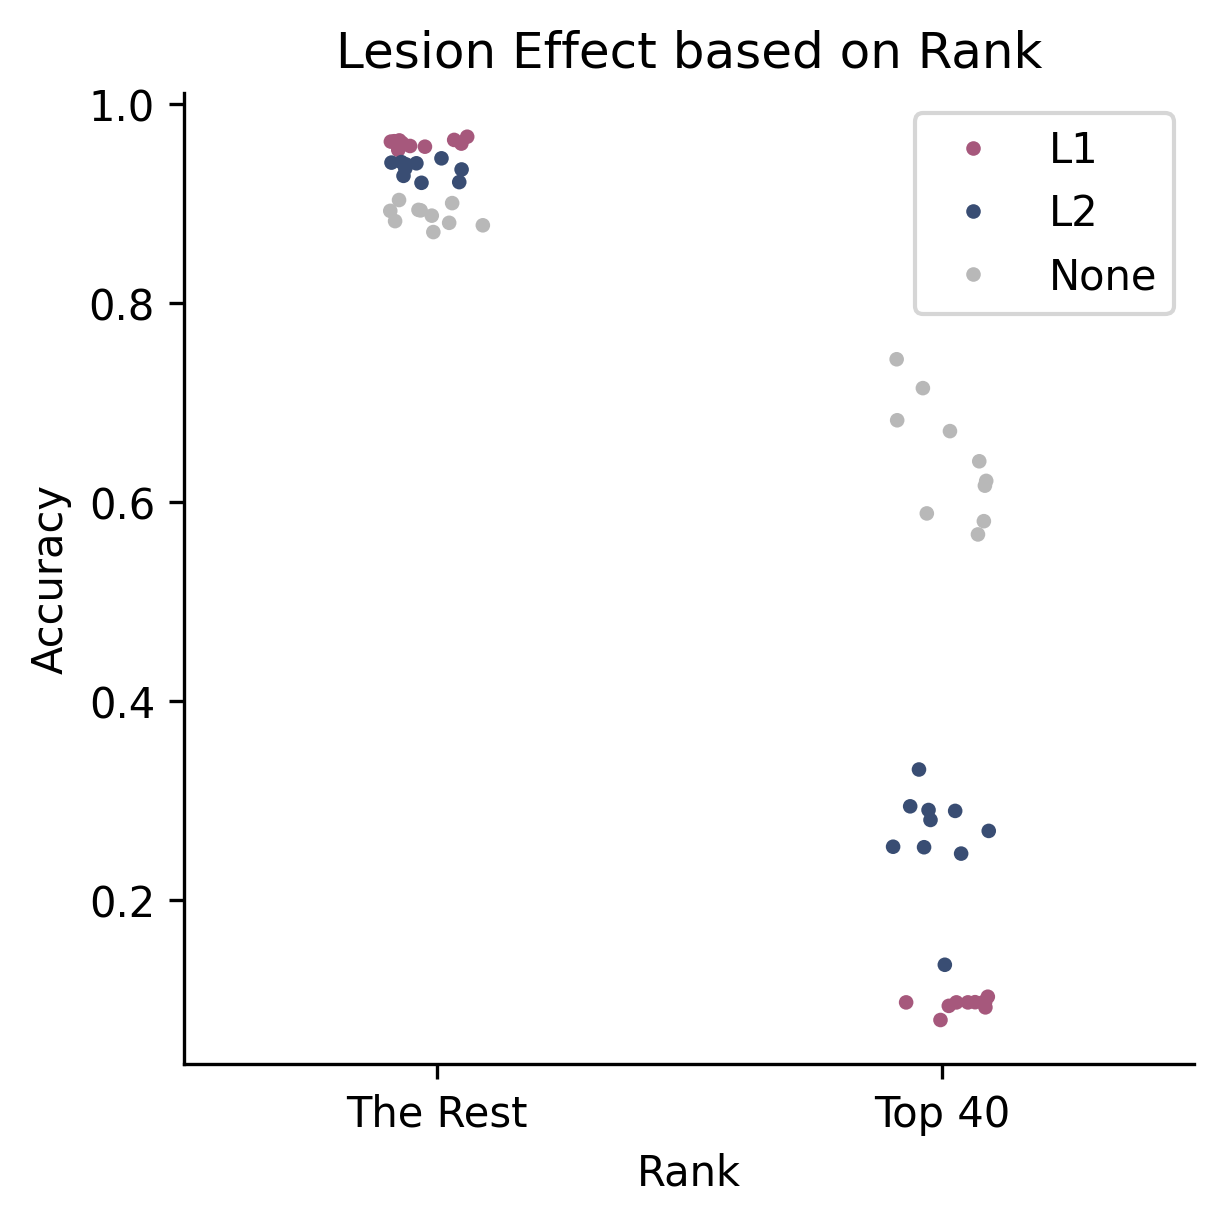

In [10]:
df = pd.DataFrame(df_accuracy_drop)
plt.figure(figsize=(10*CM,10*CM), dpi = 300)
sns.stripplot(data=df[df.Rank != "No Lesion"], hue="routine", y="Accuracy", x="Rank", palette=[PURPLE,NIGHT_BLUE,GRAY],size=3.5)
plt.xticks(ticks=[0,1],labels=["The Rest","Top 40"],rotation=0)
plt.title("Lesion Effect based on Rank")
plt.legend()
sns.despine(trim=False)
plt.tight_layout(pad=0.2)
#plt.savefig(f"figures/Lesion based on rank.pdf",dpi=600,bbox_inches='tight')

In [11]:
def index_of_distributed_computation(contributions):
    """
    Computes the entropy-based metric for neuron contributions.

    Parameters:
    contributions (numpy.ndarray): Array of neuron contributions (can be negative).

    Returns:
    float: Entropy-based metric ranging between 0 and 1.
    """
    # Step 1: Calculate squared contributions
    s = contributions ** 2

    # Step 2: Compute total squared contributions
    S = np.sum(s)

    # Handle the case where S is zero to avoid division by zero
    if S == 0:
        return 0.0

    # Step 3: Compute normalized contributions
    p = s / S

    # Replace zeros in p with a small epsilon to avoid log(0)
    epsilon = 1e-10
    p = np.where(p == 0, epsilon, p)

    # Step 4: Compute entropy
    H = -np.sum(p * np.log(p))

    # Step 5: Compute maximum possible entropy
    N = len(contributions)
    H_max = np.log(N)

    # Step 6: Normalize the entropy to get the metric between 0 and 1
    M = H / H_max if H_max != 0 else 0.0

    # Ensure M is between 0 and 1
    M = max(0.0, min(1.0, M))

    return M


In [12]:
distribution_of_processing_mnist = np.zeros((len(types_of_regularisations), len(num_neurons_list), num_trials))

for i, regularisation in enumerate(types_of_regularisations):
    for j, num_neurons in enumerate(num_neurons_list):
        shapley_results = manager.get_results(regularisation=regularisation, num_neurons=num_neurons)
        for k, shapley_result in enumerate(shapley_results):
            distribution_of_processing_mnist[i, j, k] = index_of_distributed_computation(shapley_result.shapley_modes.mean())

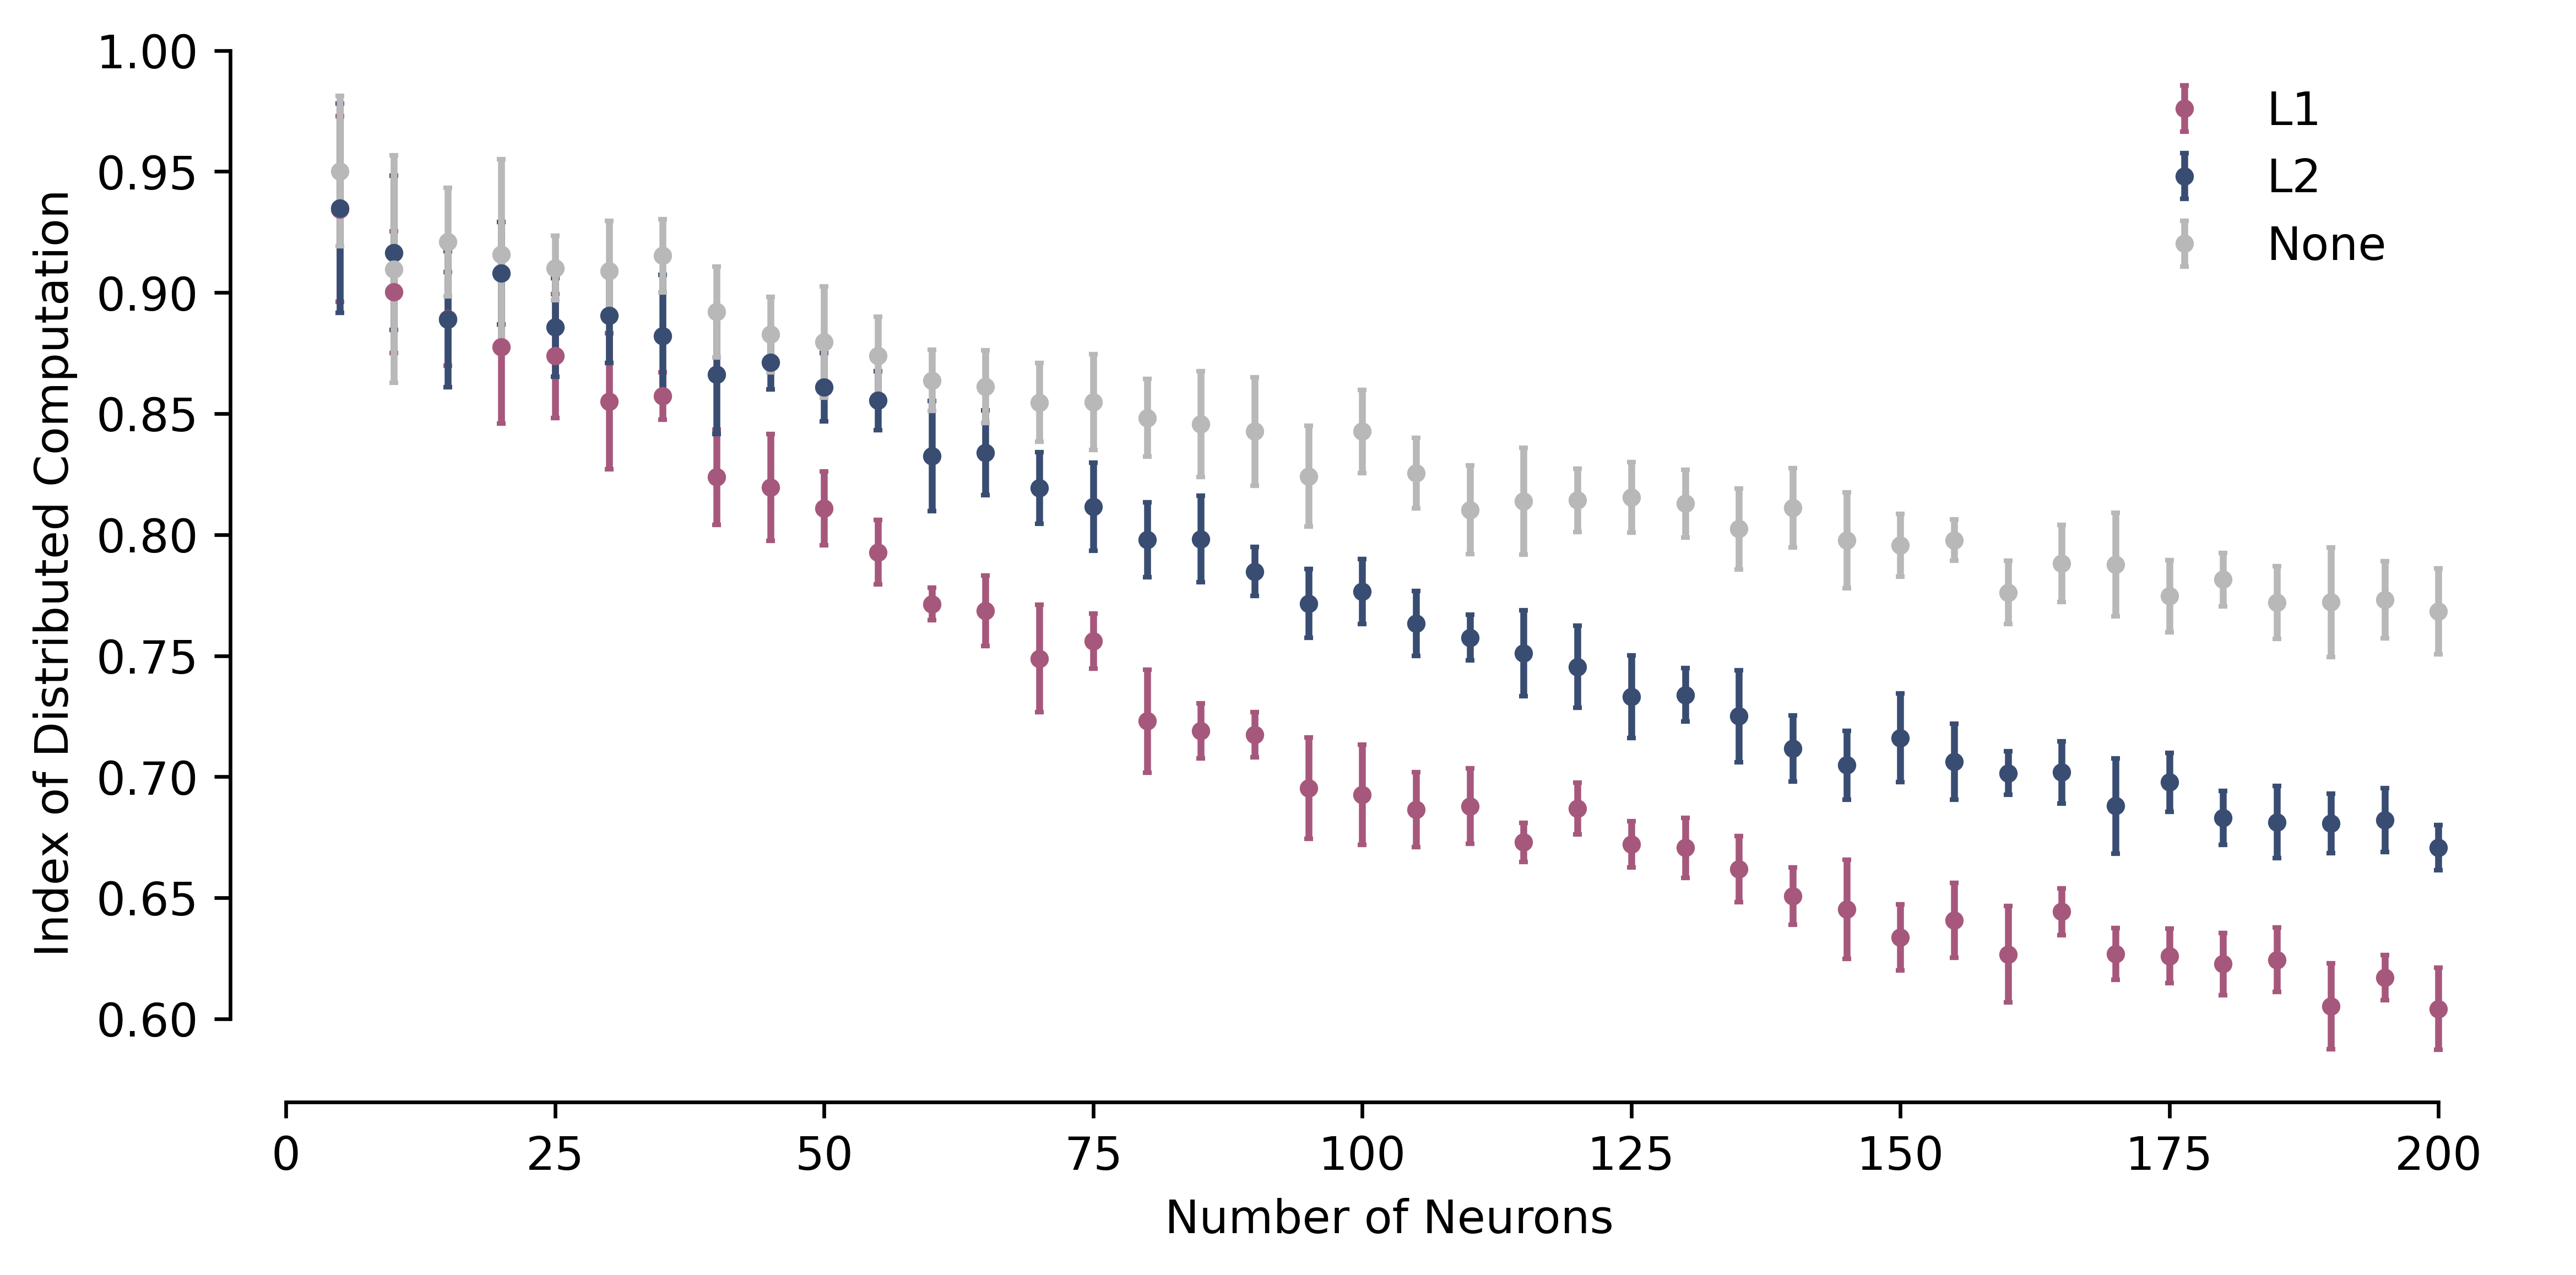

In [13]:
plt.figure(figsize=(20*CM,10*CM),dpi = 600)
plt.errorbar(x=num_neurons_list, y=distribution_of_processing_mnist[0].mean(1), fmt='.', label="L1", yerr=distribution_of_processing_mnist[0].std(1), capsize=1,color = PURPLE)
plt.errorbar(x=num_neurons_list, y=distribution_of_processing_mnist[1].mean(1), fmt='.', label="L2", yerr=distribution_of_processing_mnist[1].std(1), capsize=1, color = NIGHT_BLUE)
plt.errorbar(x=num_neurons_list, y=distribution_of_processing_mnist[2].mean(1), fmt='.', label="None", yerr=distribution_of_processing_mnist[2].std(1), capsize=1, color = GRAY)
plt.xlabel("Number of Neurons")
plt.ylabel("Index of Distributed Computation")

plt.legend(bbox_to_anchor=(0.95, 1),frameon=False,)
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)
plt.savefig(f"figures/Regularization Effect on Distributed Computation.pdf",dpi=600,bbox_inches='tight')

In [14]:
l1_reg_shapley_modes = manager.get_results(regularisation="l1 regularization", num_neurons=105)[0].shapley_modes
l2_reg_shapley_modes = manager.get_results(regularisation="l2 regularization", num_neurons=105)[0].shapley_modes
no_reg_shapley_modes = manager.get_results(regularisation="none regularization", num_neurons=105)[0].shapley_modes

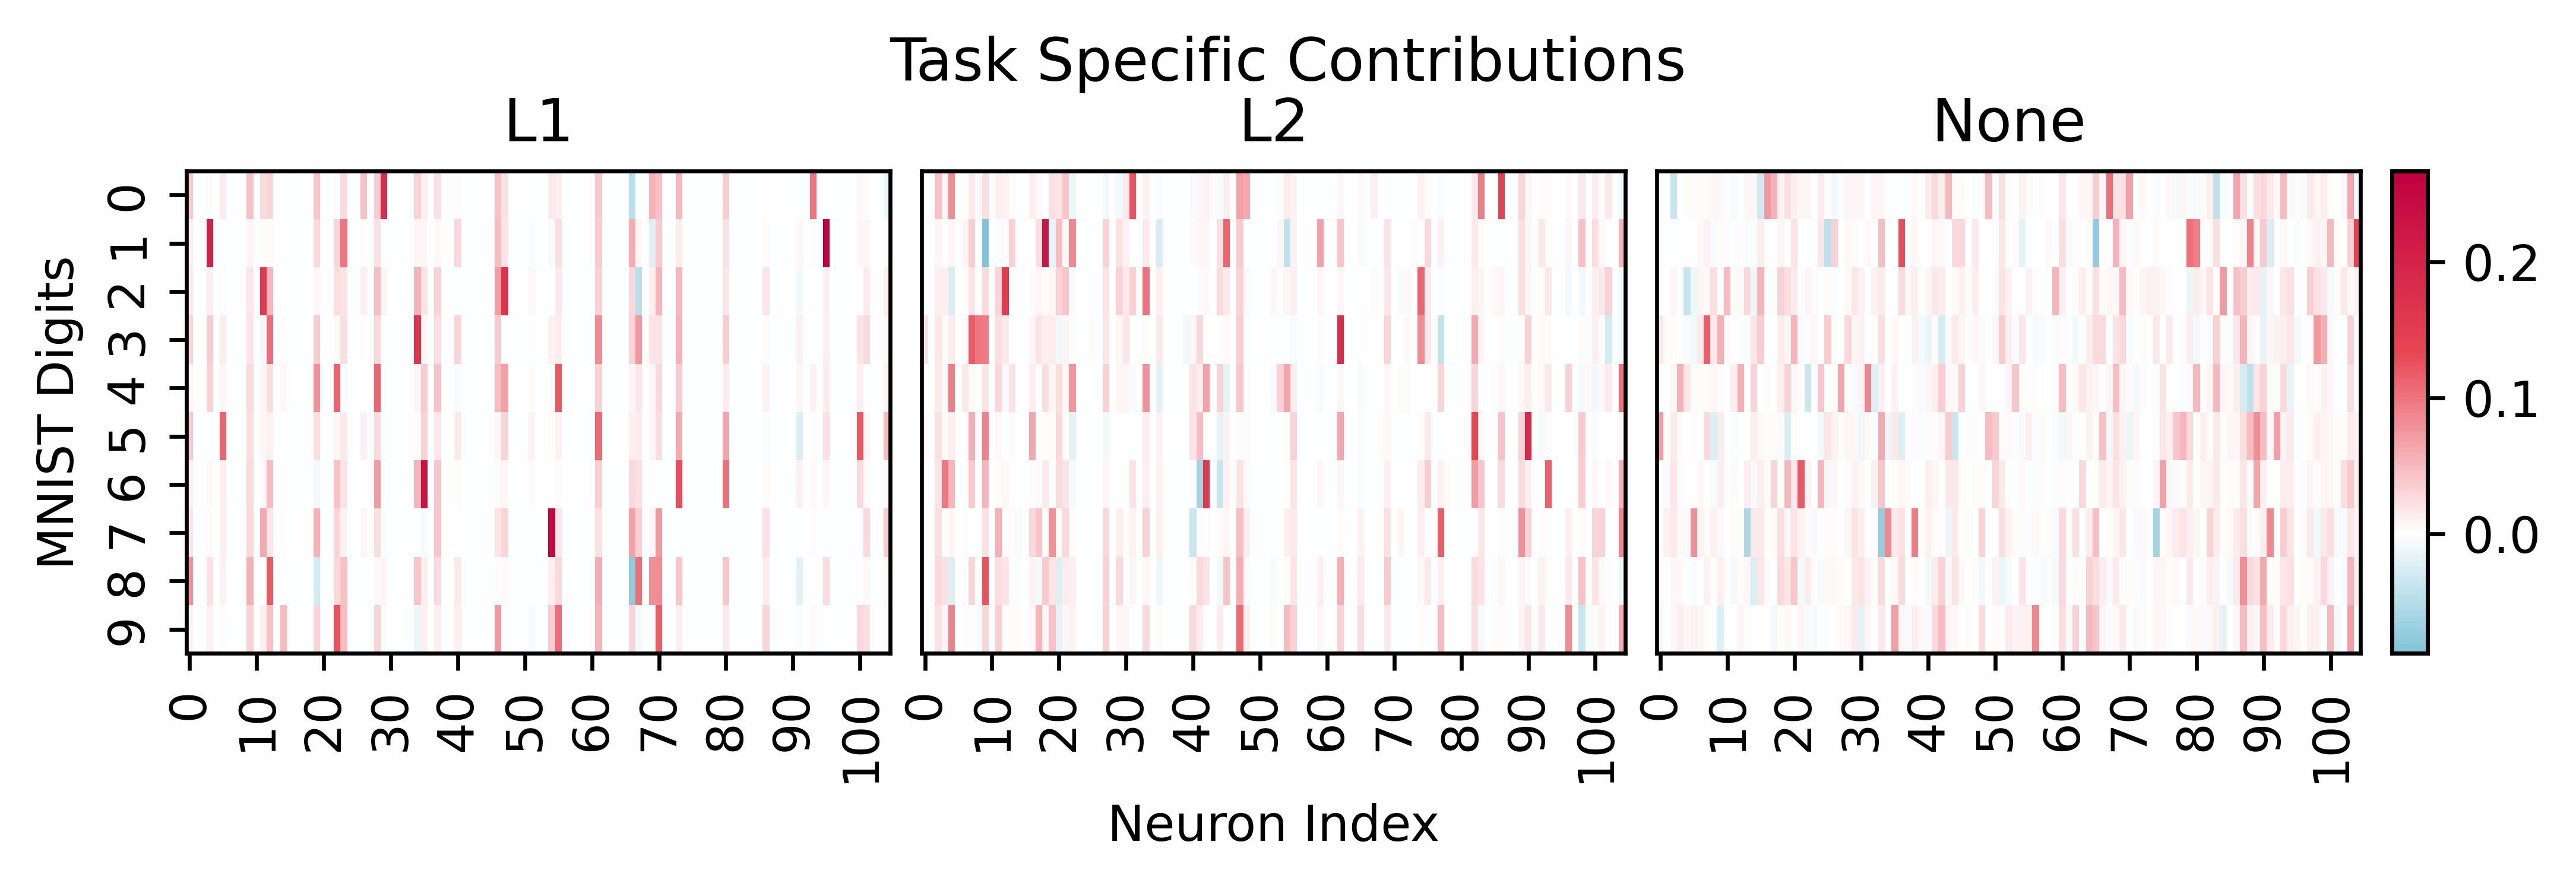

In [15]:
fig, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[4,4, 4,0.2]), dpi=600, figsize=(18*CM, 6*CM))
fig.suptitle("Task Specific Contributions")

vmin = min(l1_reg_shapley_modes.values.min(), l2_reg_shapley_modes.values.min(), no_reg_shapley_modes.values.min())
vmax = max(l1_reg_shapley_modes.values.max(), l2_reg_shapley_modes.values.max(), no_reg_shapley_modes.values.max())

sns.heatmap(l1_reg_shapley_modes, annot=False, cbar=False, ax=axs[0], vmin=vmin, vmax=vmax, cmap=diverge_from_white,center=0)
sns.heatmap(l2_reg_shapley_modes, annot=False, yticklabels=False, cbar=False, ax=axs[1], vmax=vmax, vmin=vmin, cmap=diverge_from_white,center=0)
sns.heatmap(no_reg_shapley_modes, annot=False, yticklabels=False, cbar=False, ax=axs[2], vmax=vmax, vmin=vmin, cmap=diverge_from_white,center=0)

fig.colorbar(axs[2].collections[0], cax=axs[3])
axs[0].set_ylabel("MNIST Digits")
axs[0].set_title("L1")
axs[1].set_title("L2")
axs[2].set_title("None")
axs[1].set_xlabel("Neuron Index")

sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

fig.tight_layout(pad=0.2)
plt.savefig(f"figures/Digit Wise Shapley Values.pdf",dpi=600,bbox_inches='tight')

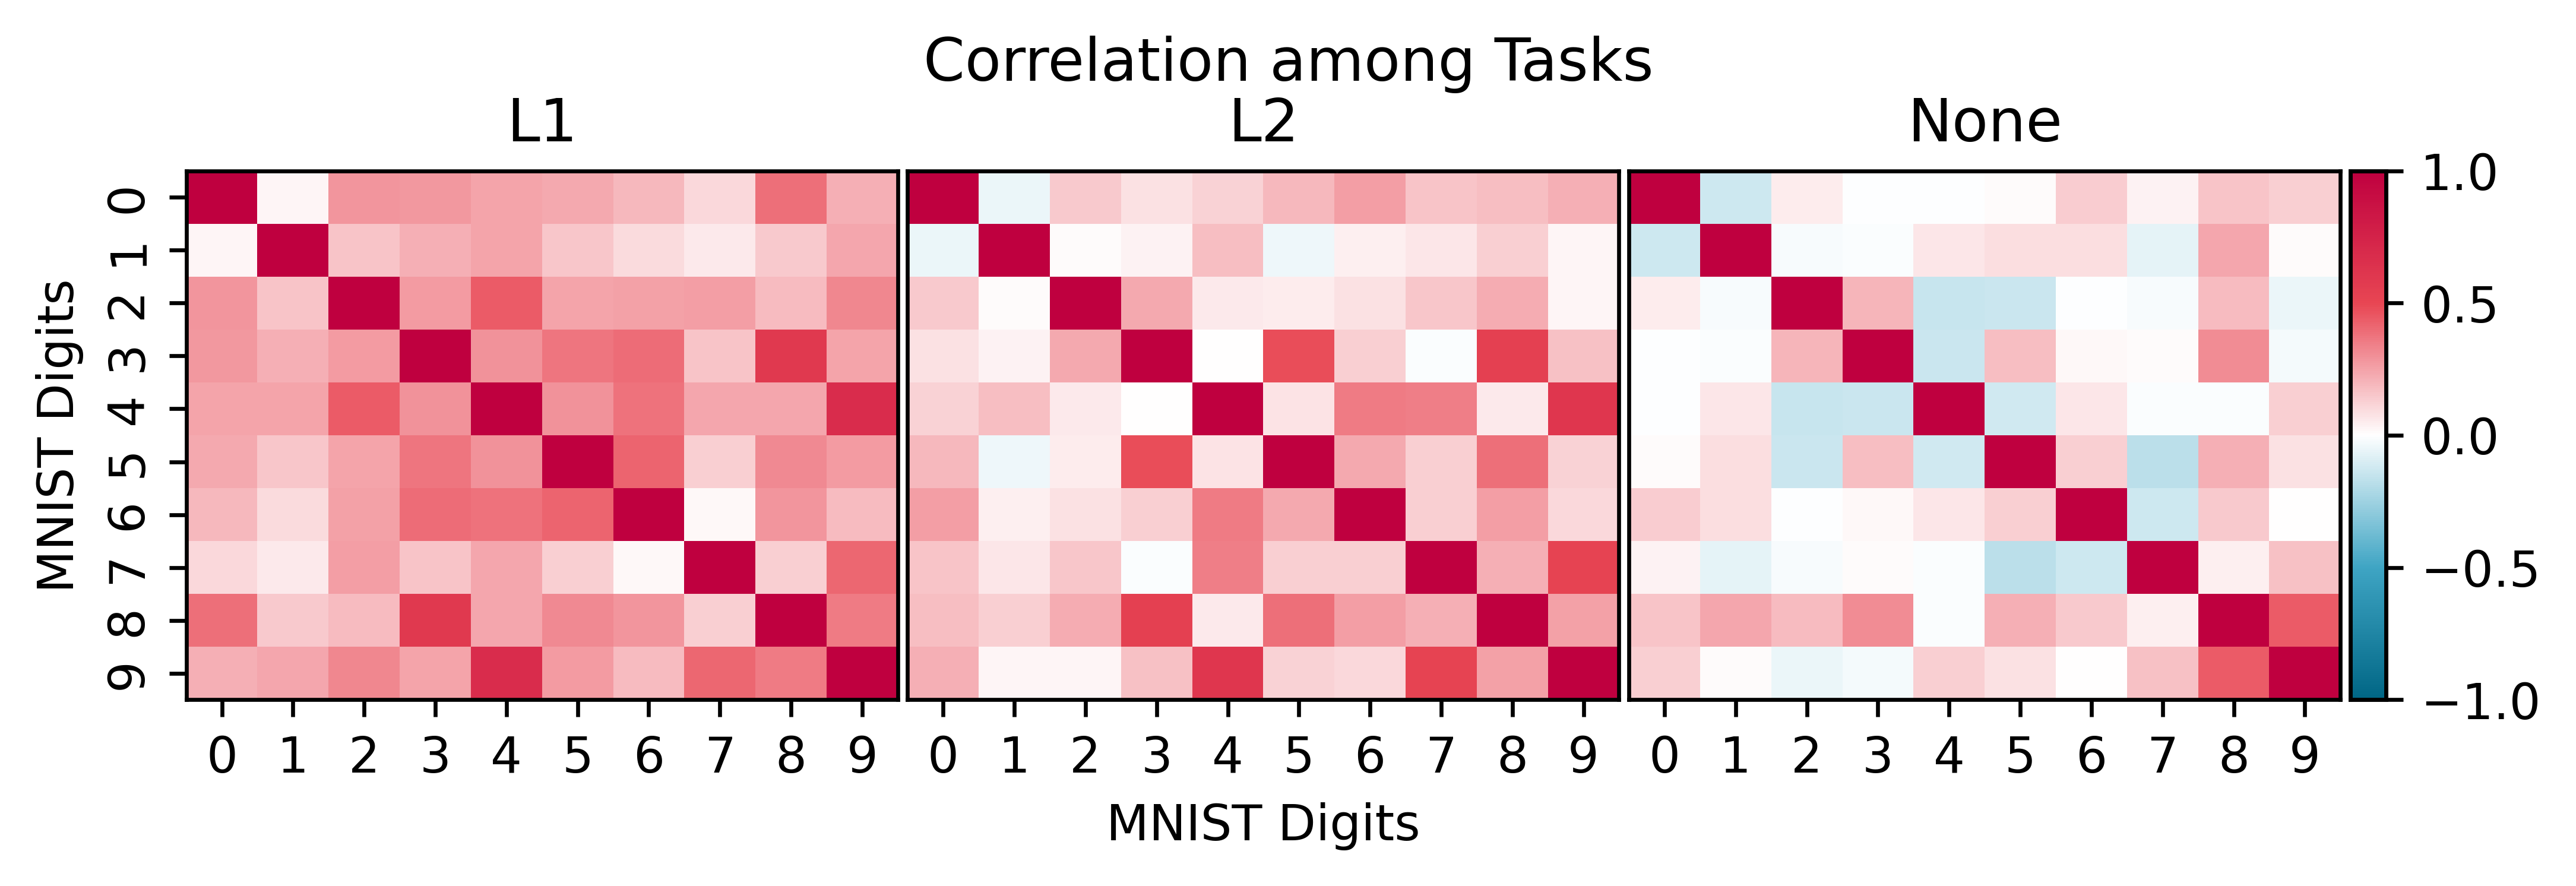

In [16]:
fig, axs = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[4,4, 4,0.2]), dpi=600, figsize=(18*CM, 6*CM))
fig.suptitle("Correlation among Tasks")


correlation_l1 = np.corrcoef(l1_reg_shapley_modes.values, rowvar=True)
correlation_l2 = np.corrcoef(l2_reg_shapley_modes.values, rowvar=True)
correlation_no = np.corrcoef(no_reg_shapley_modes.values, rowvar=True)


sns.heatmap(correlation_l1, annot=False, cbar=False, ax=axs[0], vmin=-1, vmax=1, cmap=diverge_from_white,center=0)
sns.heatmap(correlation_l2, annot=False, yticklabels=False, cbar=False, ax=axs[1], vmax=1, vmin=-1, cmap=diverge_from_white,center=0)
sns.heatmap(correlation_no, annot=False, yticklabels=False, cbar=False, ax=axs[2], vmax=1, vmin=-1, cmap=diverge_from_white,center=0)

fig.colorbar(axs[2].collections[0], cax=axs[3])
axs[0].set_ylabel("MNIST Digits")
axs[0].set_title("L1")
axs[1].set_title("L2")
axs[2].set_title("None")
axs[1].set_xlabel("MNIST Digits")

sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

fig.tight_layout(pad=0.2)
plt.savefig(f"figures/Digit Wise Correlation.pdf",dpi=600,bbox_inches='tight')

In [18]:
correlation_matrix = np.zeros((len(types_of_regularisations), len(num_neurons_list), num_trials))

for i, regularisation in enumerate(types_of_regularisations):
    for j, num_neurons in enumerate(num_neurons_list):
        shapley_results = manager.get_results(regularisation=regularisation, num_neurons=num_neurons)
        for k, shapley_result in enumerate(shapley_results):
            outgoing_weights = shapley_result.model.layer2[1].weight.abs().mean(0).detach().cpu().numpy()
            incoming_weights = shapley_result.model.layer1.weight.abs().mean(1).detach().cpu().numpy()
            average_weights = (outgoing_weights + incoming_weights) / 2
            contributions = shapley_result.shapley_modes.values.mean(0)
            correlation_matrix[i, j, k] = pearsonr(average_weights, contributions)[0]

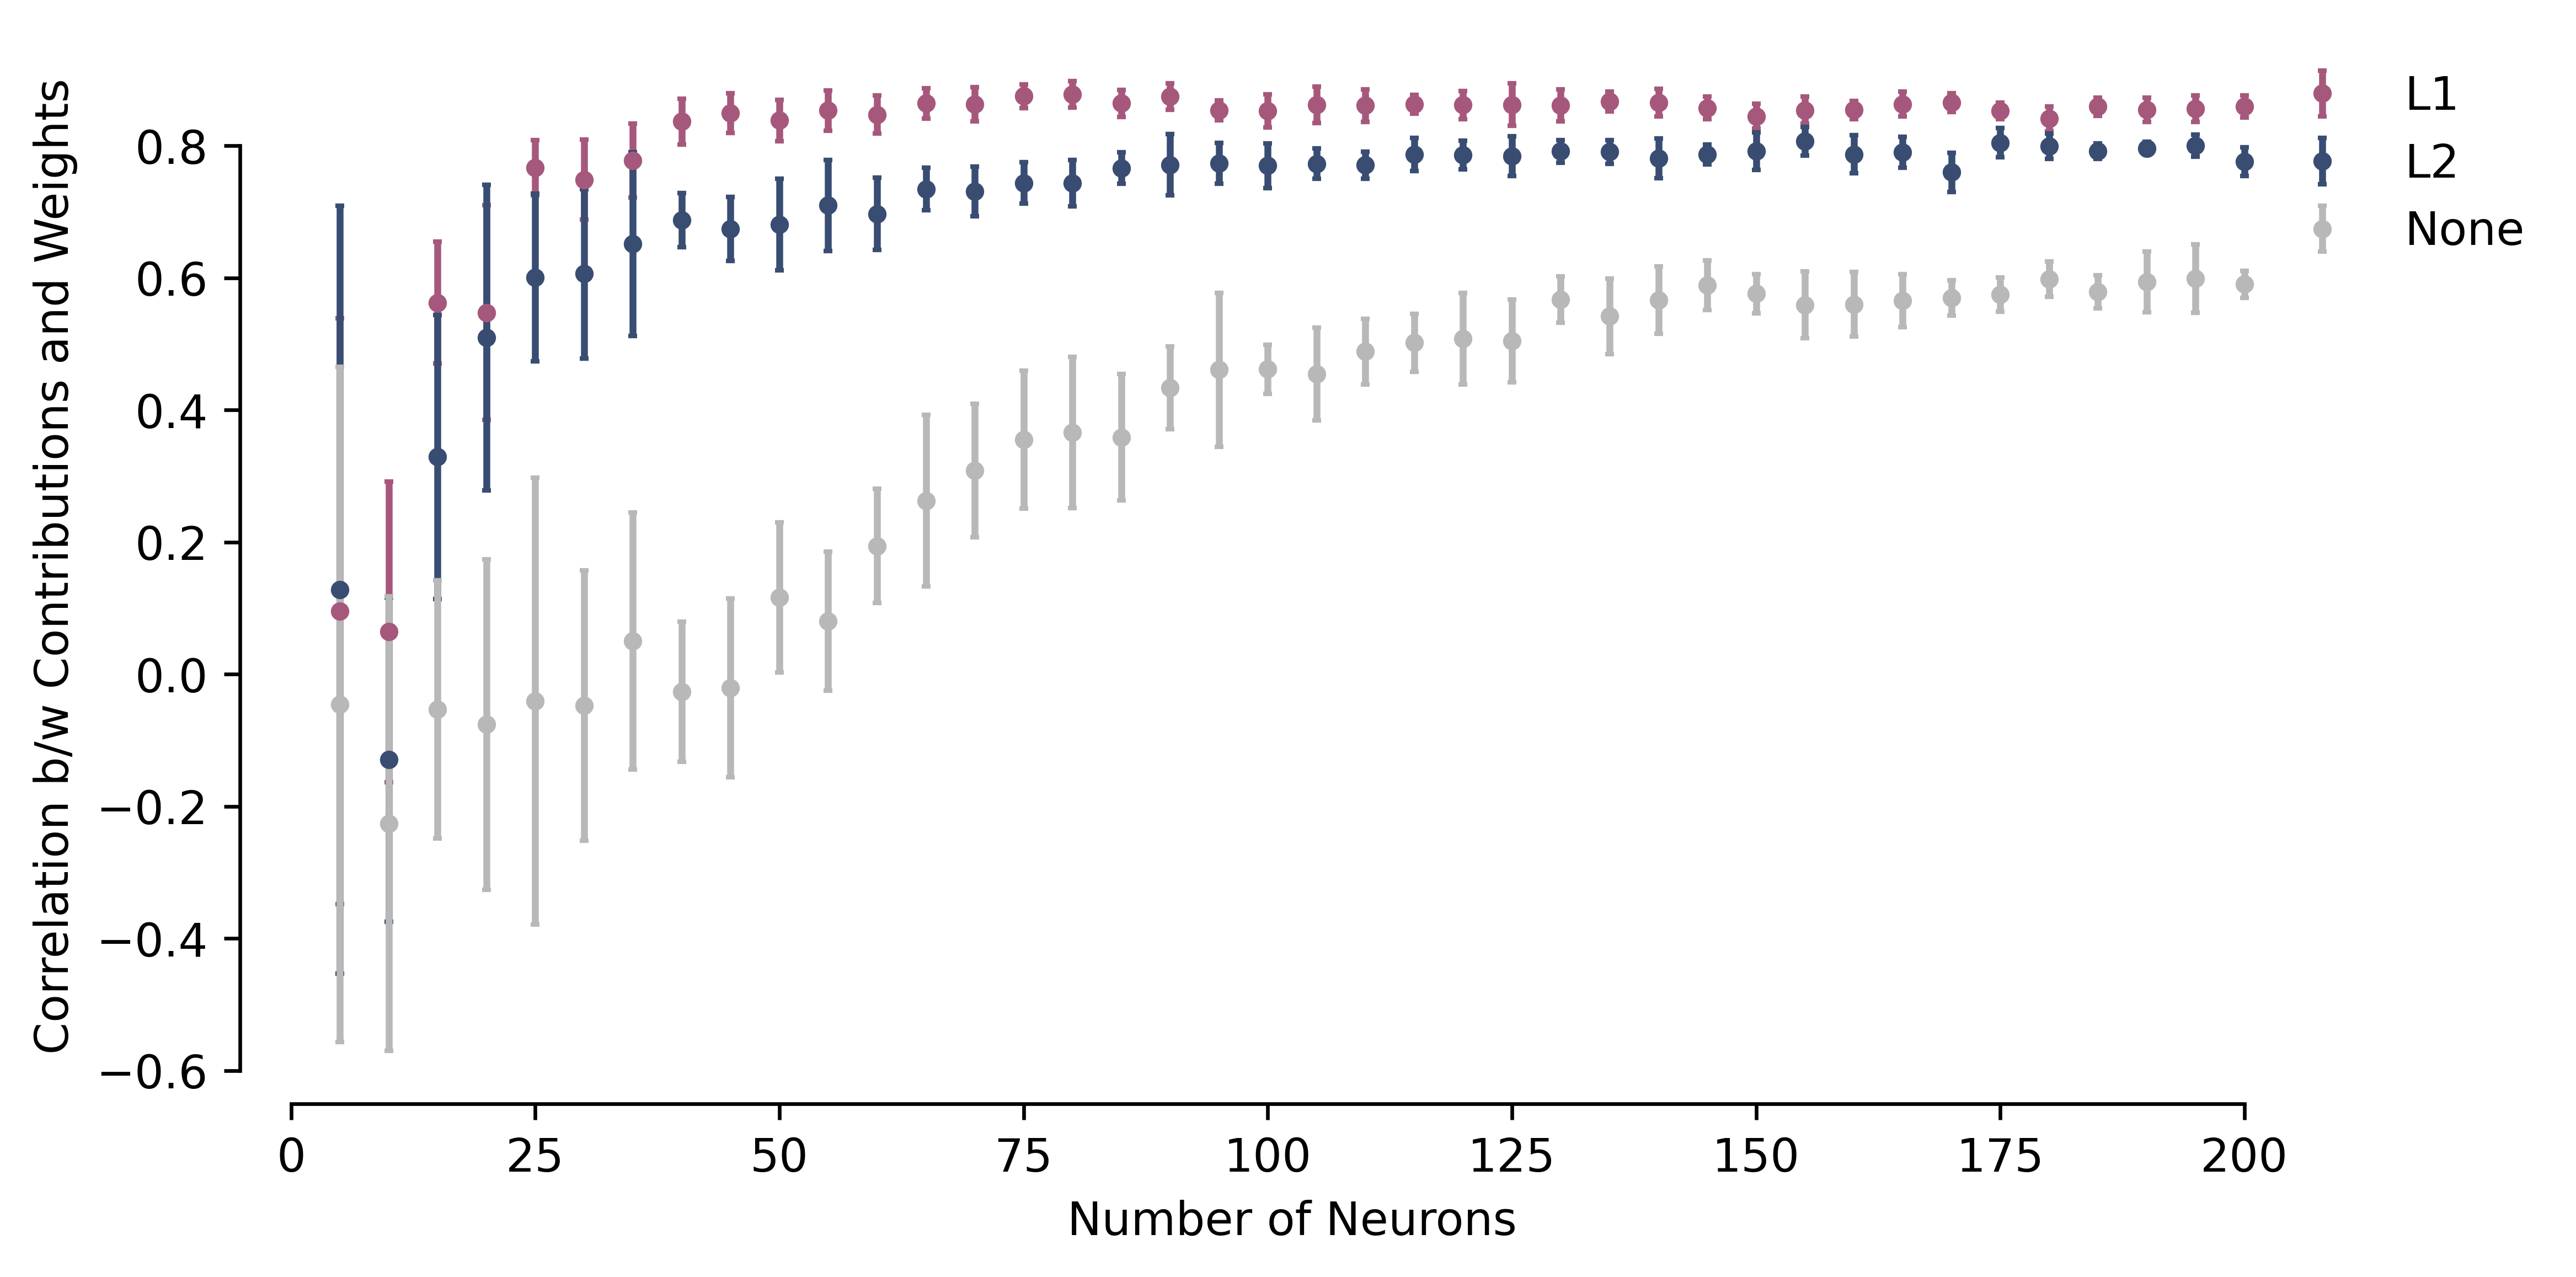

In [19]:
plt.figure(figsize=(20*CM,10*CM),dpi = 600)
plt.errorbar(x=num_neurons_list, y=correlation_matrix[0].mean(1), fmt='.', label="L1", yerr=correlation_matrix[0].std(1), capsize=1,color = PURPLE)
plt.errorbar(x=num_neurons_list, y=correlation_matrix[1].mean(1), fmt='.', label="L2", yerr=correlation_matrix[1].std(1), capsize=1, color = NIGHT_BLUE)
plt.errorbar(x=num_neurons_list, y=correlation_matrix[2].mean(1), fmt='.', label="None", yerr=correlation_matrix[2].std(1), capsize=1, color = GRAY)
plt.xlabel("Number of Neurons")
plt.ylabel("Correlation b/w Contributions and Weights")

plt.legend(bbox_to_anchor=(0.95, 1),frameon=False,)
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)

plt.savefig(f"figures/Correlation between Weights and Contributions.pdf",dpi=600,bbox_inches='tight')

In [18]:
distribution_of_processing_mnist = np.zeros((3, len(num_neurons_list), num_trials))

digits = [0, 1, 9]

for i, digit in enumerate(digits):
    for j, num_neurons in enumerate(num_neurons_list):
        shapley_results = manager.get_results(regularisation="l2 regularization", num_neurons=num_neurons)
        for k, shapley_result in enumerate(shapley_results):
            distribution_of_processing_mnist[i, j, k] = index_of_distributed_computation(shapley_result.shapley_modes.iloc[digit])

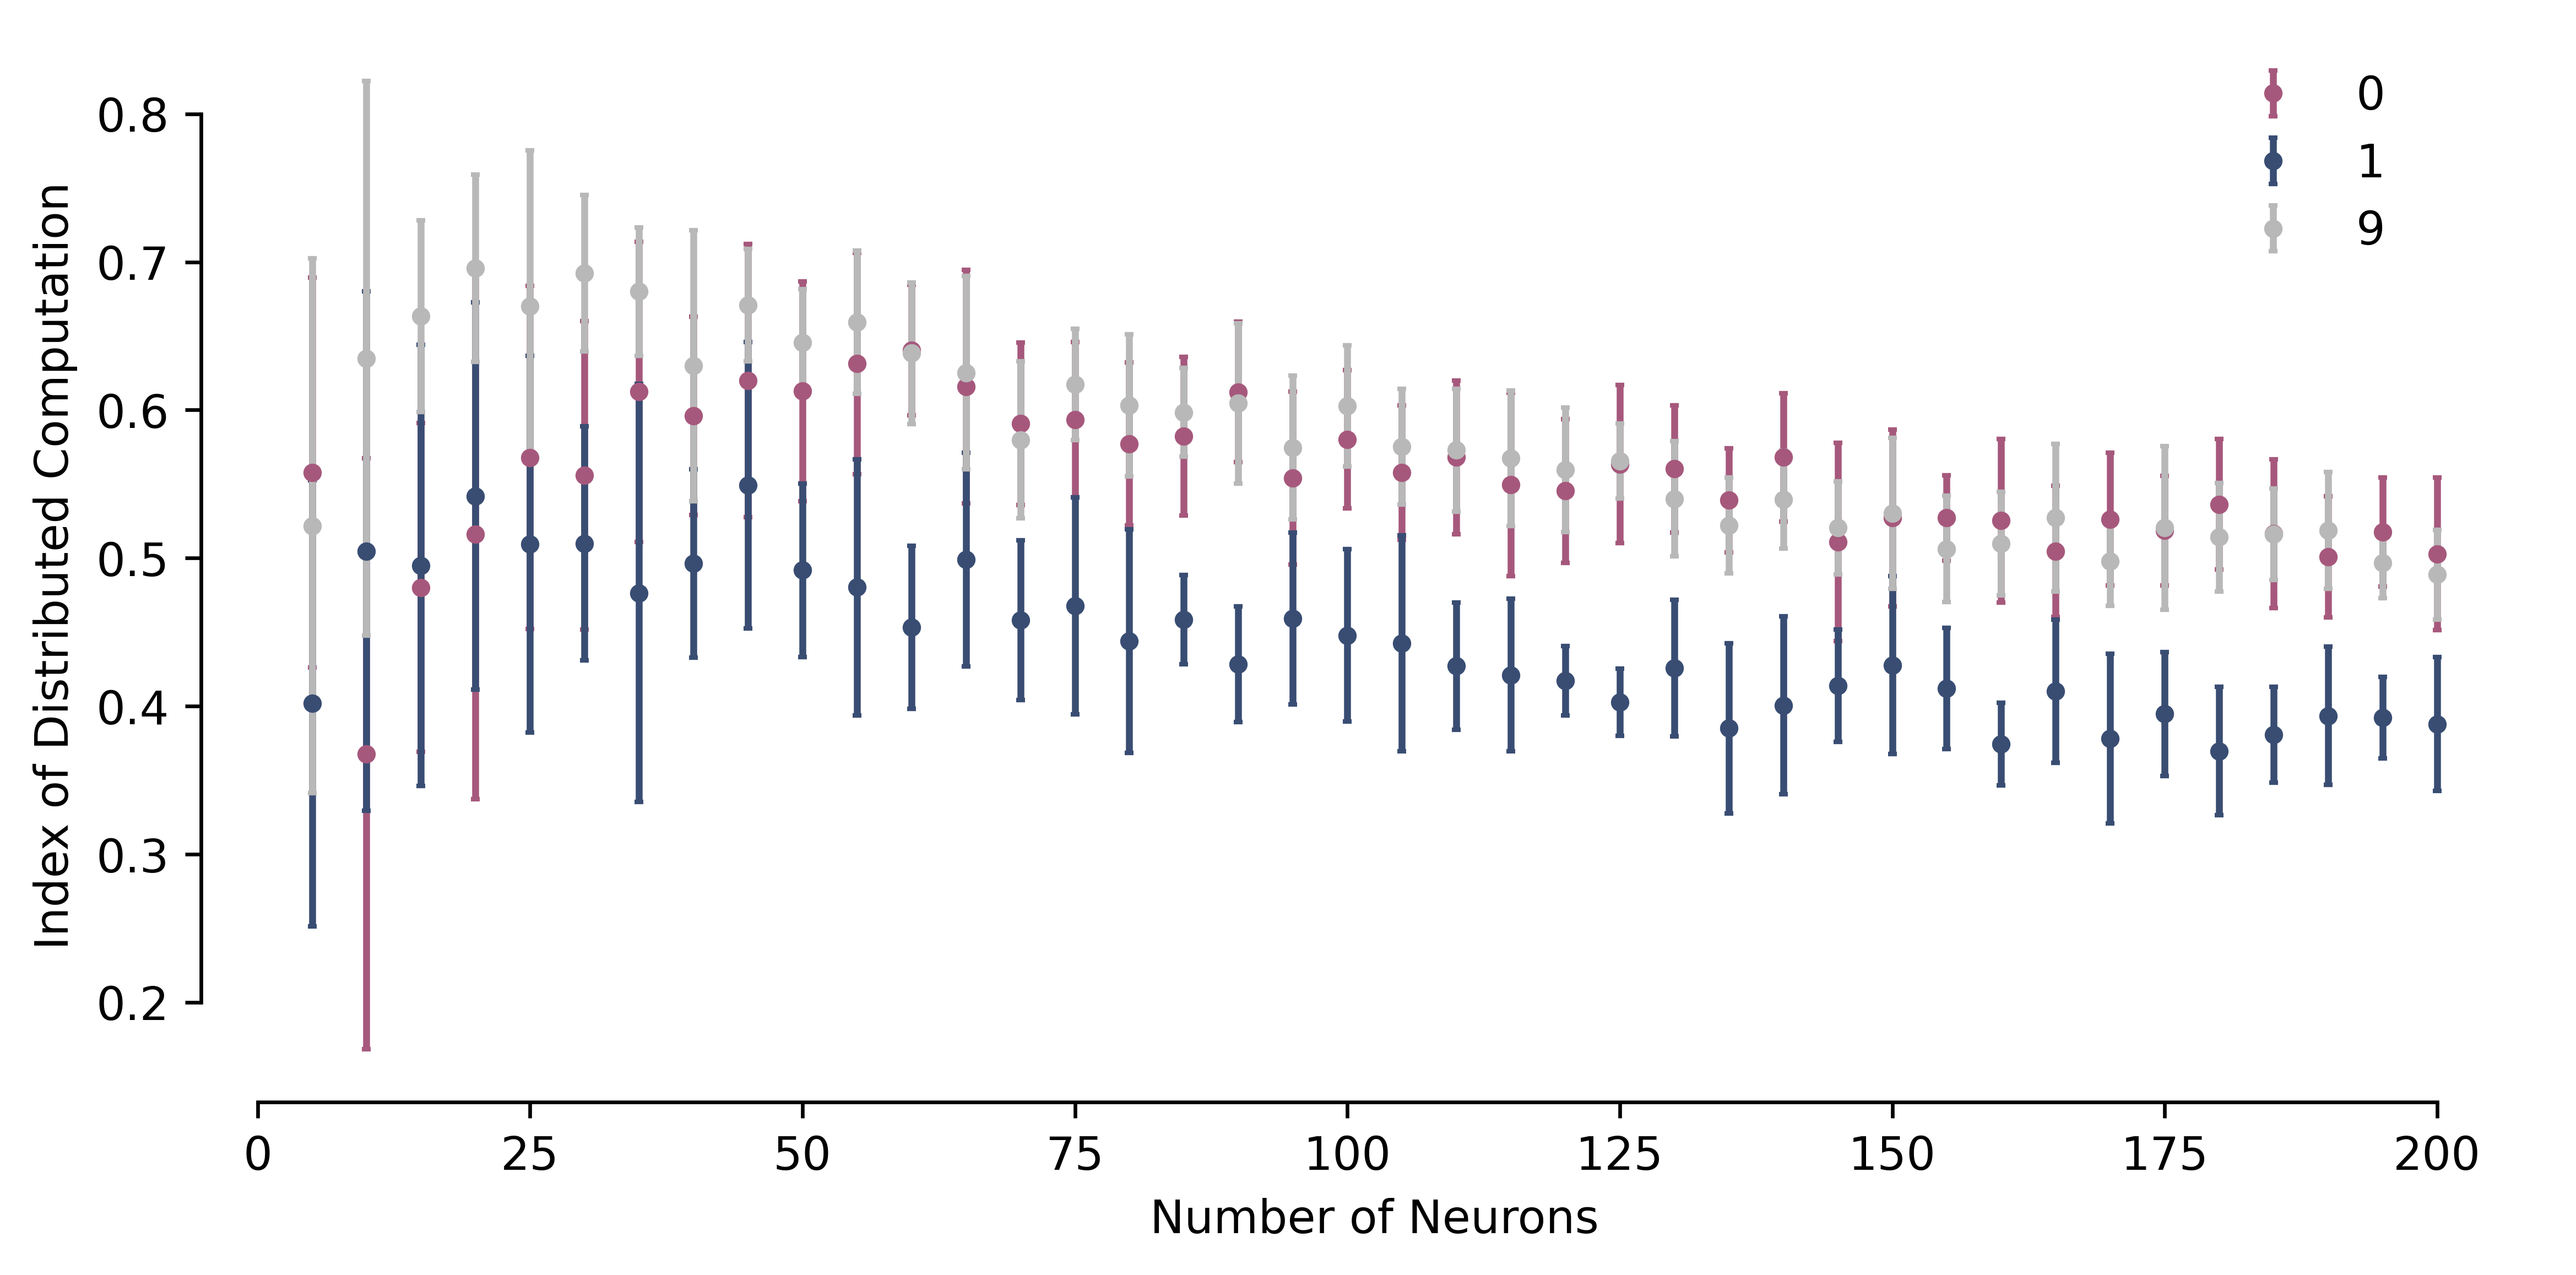

In [19]:
plt.figure(figsize=(20*CM,10*CM),dpi = 600)
COLORS = [PURPLE, NIGHT_BLUE, GRAY]

for i, digit in enumerate(digits):
    plt.errorbar(x=num_neurons_list, y=distribution_of_processing_mnist[i].mean(1), fmt='.', label=str(digit), yerr=distribution_of_processing_mnist[i].std(1), capsize=1, color = COLORS[i])
plt.xlabel("Number of Neurons")
plt.ylabel("Index of Distributed Computation")

plt.legend(bbox_to_anchor=(0.95, 1),frameon=False,)
sns.despine(offset=1, trim=True)
plt.tight_layout(pad=1)
plt.savefig(f"figures/Index of Distributed Computation Digit Wise.pdf",dpi=600,bbox_inches='tight')

In [17]:
num_neurons_list = sorted(num_neurons_list)

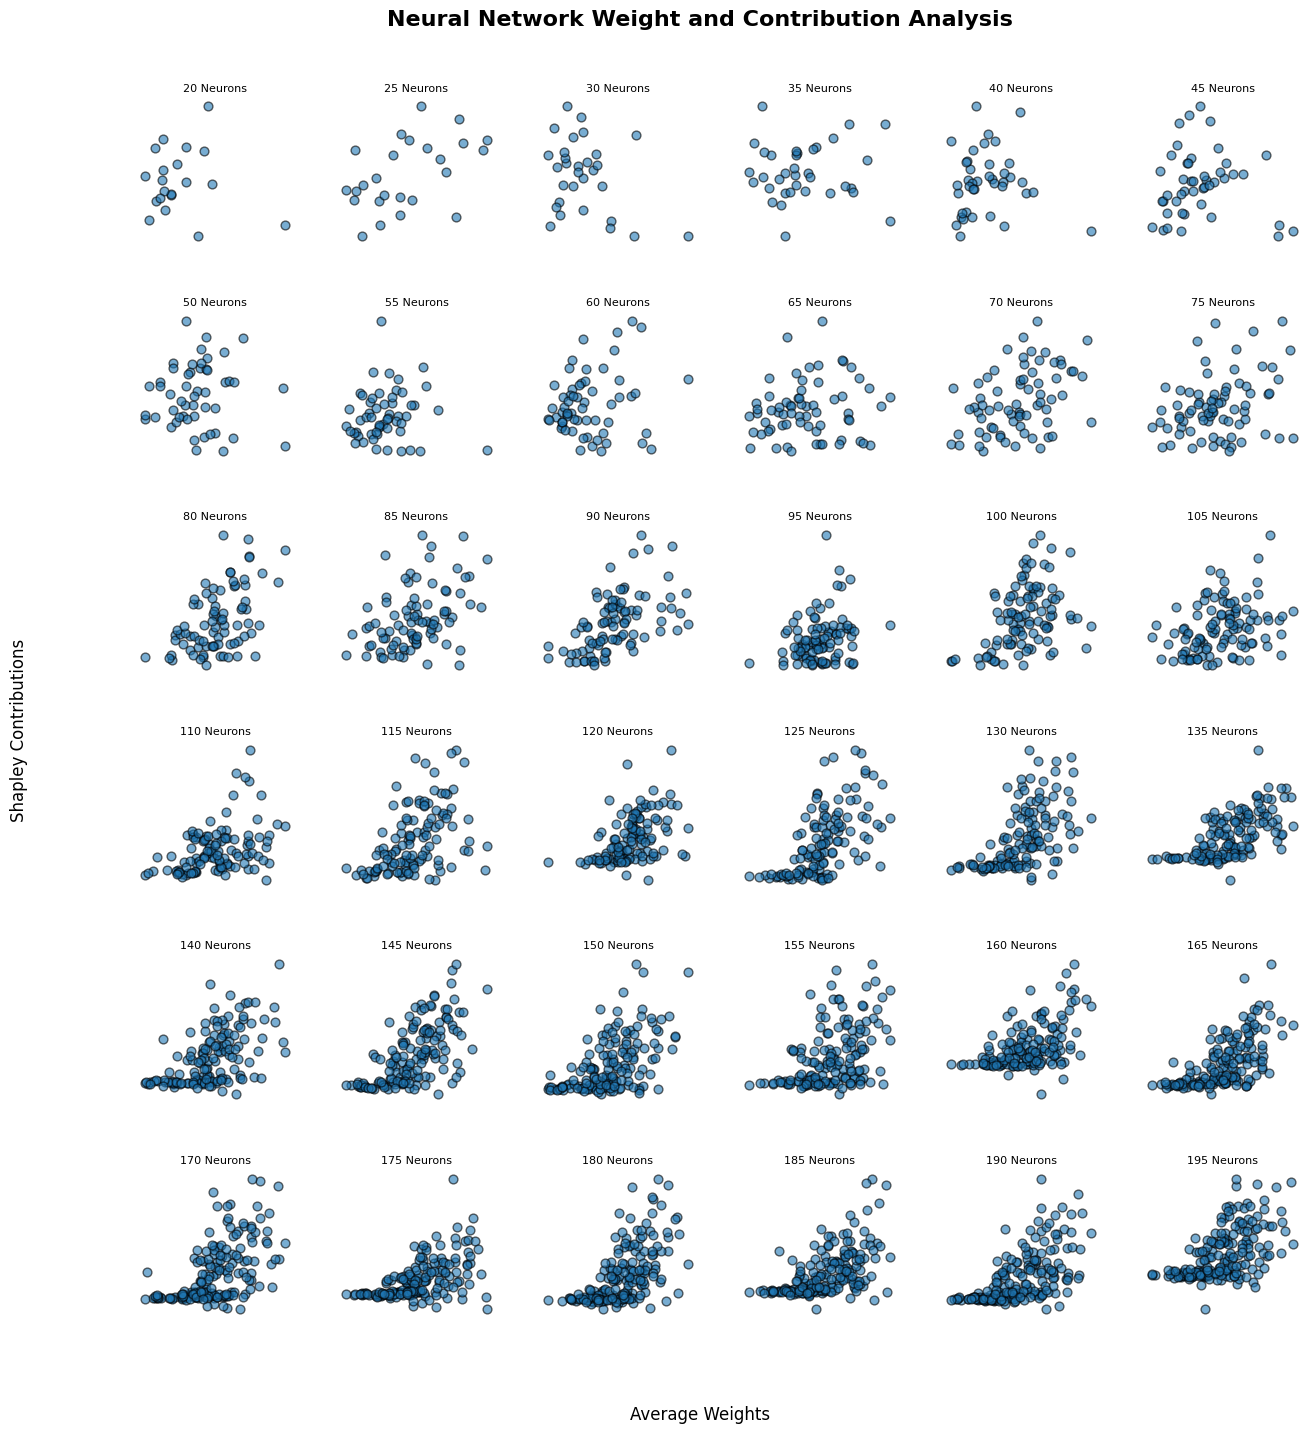

In [21]:
import matplotlib.pyplot as plt

rows, cols = 6, 6
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Replace the following with your actual plotting logic
    relevant_results = manager.get_results(regularisation="none regularization", num_neurons=num_neurons_list[3:-1][i])
    incoming_weights = relevant_results[0].model.layer1.weight.abs().mean(1).detach().cpu().numpy()
    outgoing_weights = relevant_results[0].model.layer2[1].weight.abs().mean(0).detach().cpu().numpy()
    average_weights = (outgoing_weights + incoming_weights) / 2

    contributions = relevant_results[0].shapley_modes.values.mean(0)
    
    # Scatter plot with circular, translucent dots
    ax.scatter(average_weights, contributions, alpha=0.6, s=40, edgecolor="k")  # s adjusts the size of dots
    ax.set_title(f'{num_neurons_list[3:-1][i]} Neurons', fontsize=8)
    ax.axis('off')  # Optional: Turn off individual axes for cleaner look

# Overall figure title and axis labels
fig.suptitle("Neural Network Weight and Contribution Analysis", fontsize=16, fontweight='bold')
fig.text(0.5, 0.04, "Average Weights", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Shapley Contributions", va='center', rotation='vertical', fontsize=12)

plt.subplots_adjust(top=0.92, wspace=0.3, hspace=0.5)  # Adjust layout for better spacing
plt.show()


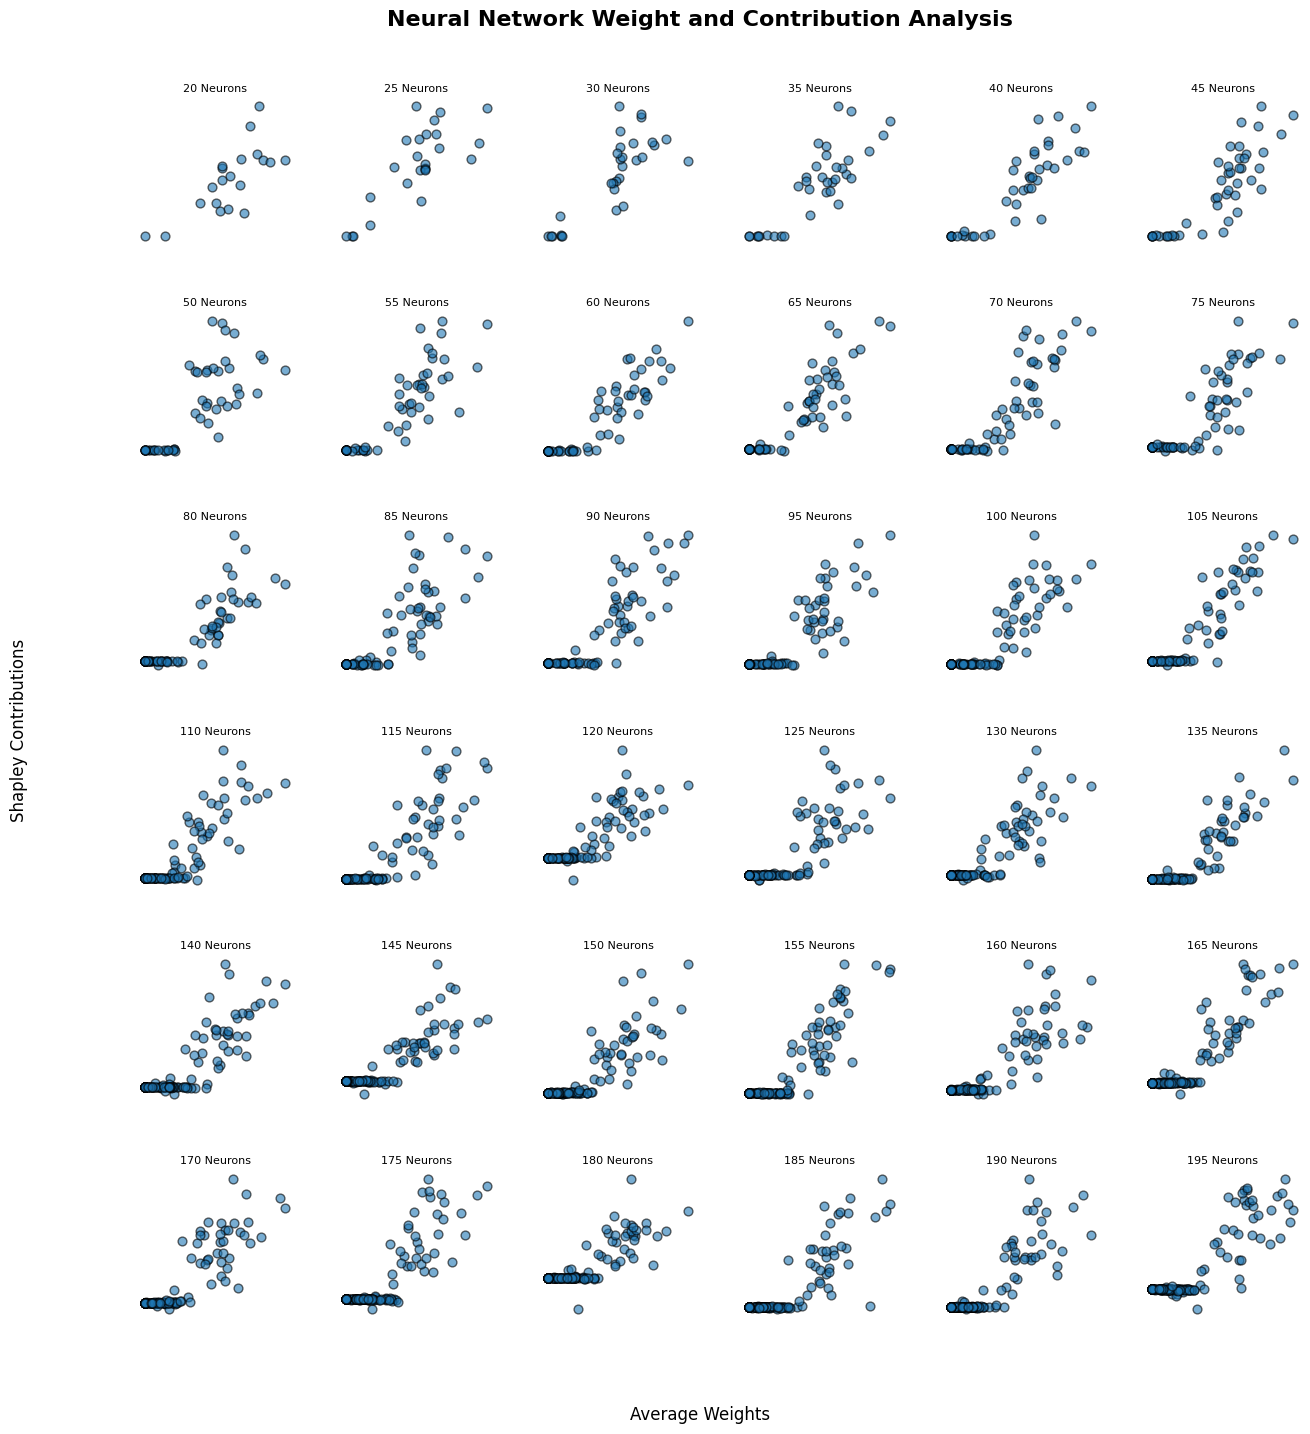

In [11]:

rows, cols = 6, 6
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Replace the following with your actual plotting logic
    relevant_results = manager.get_results(regularisation="l1 regularization", num_neurons=num_neurons_list[3:-1][i])
    incoming_weights = relevant_results[0].model.layer1.weight.abs().mean(1).detach().cpu().numpy()
    outgoing_weights = relevant_results[0].model.layer2[1].weight.abs().mean(0).detach().cpu().numpy()
    average_weights = (outgoing_weights + incoming_weights) / 2

    contributions = relevant_results[0].shapley_modes.values.mean(0)
    
    # Scatter plot with circular, translucent dots
    ax.scatter(average_weights, contributions, alpha=0.6, s=40, edgecolor="k")  # s adjusts the size of dots
    ax.set_title(f'{num_neurons_list[3:-1][i]} Neurons', fontsize=8)
    ax.axis('off')  # Optional: Turn off individual axes for cleaner look

# Overall figure title and axis labels
fig.suptitle("Neural Network Weight and Contribution Analysis", fontsize=16, fontweight='bold')
fig.text(0.5, 0.04, "Average Weights", ha='center', fontsize=12)
fig.text(0.04, 0.5, "Shapley Contributions", va='center', rotation='vertical', fontsize=12)

plt.subplots_adjust(top=0.92, wspace=0.3, hspace=0.5)  # Adjust layout for better spacing
plt.show()
